In [1]:
# import packages
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as sp
%load_ext google.cloud.bigquery
import pickle
from matplotlib import pyplot as plt
with open('design.pkl','rb') as f:
    set_params = pickle.load(f)
plt.rcParams.update(set_params)

from google.cloud import bigquery

In [2]:
# Modules
from modules.connector import MyBigQuery, MySQL

bq = MyBigQuery(
    credentials_file="./credentials/New AutoMotive Index-487e031dc242.json"
)

In [3]:
def co2ComplianceAdjFunc(row, total_trading_diff_perc):
    #checks for nan
    if row.co2Compliance > 0:
        co2Compliance = row.co2Compliance * total_trading_diff_perc
    
        return co2Compliance
    else:
        return row.co2Compliance

def co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2ComplianceAdj / 167
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    
    if new_zev_credits > 0:
        return new_zev_credits
    else:
        return 0
        
def proposed_co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    conversion_factor = row.co2Target
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2Compliance / conversion_factor
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    return new_zev_credits

In [4]:
mandate = 0.1

# Latest Compliance

In [5]:
def ft_cleaner(x):
    x = x.replace('GAS BI-FUEL', 'Other').replace('GAS', 'Other').replace('GAS DIESEL', 'Other').replace('PETROL/GAS', 'Other').replace('LPG', 'Other').replace('STEAM', 'Other').replace('LNG', 'Other').replace('OTHER', 'Other').replace('CNG', 'Other')
    x = x.replace('FUEL CELLS', 'Other')
    x = x.replace('PETROL', 'Petrol').replace('Petrol/Other', 'Petrol')
    x = x.replace('HYBRID ELECTRIC (CLEAN)', 'Hybrid').replace('HYBRID ELECTRIC', 'Hybrid').replace('ELECTRIC DIESEL', 'Hybrid')
    x = x.replace('DIESEL', 'Diesel').replace('Other Diesel', 'Diesel')
    x = x.replace('ELECTRICITY', 'Pure Electric').replace('ELECTRIC', 'Pure Electric')
    return x

In [6]:
van_targets = bq.from_bq_to_dataframe(
query = """
SELECT make, AVG(co2Emissions) as co2Target
FROM VES_dataset.VRN_UK
WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250 AND co2Emissions = 0))
AND monthOfFirstRegistration > '2020-12-31'
AND monthOfFirstRegistration < '2022-01-01'
AND co2Emissions > 0
GROUP BY make
""")

In [7]:
# %%bigquery van_targets --project rugged-baton-283921
# SELECT make, AVG(co2Emissions) as co2Target
# FROM VES_dataset.VRN_UK
# WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250 AND co2Emissions = 0))
# AND monthOfFirstRegistration > '2020-12-31'
# AND monthOfFirstRegistration < '2022-01-01'
# AND co2Emissions > 0
# GROUP BY make

In [8]:
# car_targets.sort_values('meanCo2').plot(kind='bar', x='make', figsize=(40, 10))

In [9]:
# df_activity = bq.from_bq_to_dataframe(
# query = """
# SELECT 
#     make, 
#     COUNT(*) as totalSales,
#     COUNTIF(co2Emissions > 0) as nonzevSales,
#     COUNTIF(co2Emissions = 0) as zevSales,
#     SUM(co2Emissions) as co2Activity

# FROM VES_dataset.VRN_UK
# WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250 and co2Emissions = 0))
# AND CAST(monthOfFirstRegistration AS DATE) >= '2022-05-01'
# AND CAST(monthOfFirstRegistration AS DATE) < '2023-05-01'
# AND make IN (
#     SELECT make
#     FROM VES_dataset.VRN_UK
#     WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
#     AND CAST(monthOfFirstRegistration AS DATE) >= '2022-05-01'
#     AND CAST(monthOfFirstRegistration AS DATE) < '2023-05-01'
#     -- AND total > 2500
#     GROUP BY make
#     HAVING COUNT(*) > 2500
# )
# GROUP BY make
# ORDER BY totalSales ASC;
# """
# )

In [10]:


# df_activity = bq.from_bq_to_dataframe(
# query = """
# SELECT 
#     make, 
#     COUNT(*) as totalSales,
#     COUNTIF(co2Emissions > 0) as nonzevSales,
#     COUNTIF(co2Emissions = 0) as zevSales,
#     SUM(co2Emissions) as co2Activity

# FROM VES_dataset.VRN_UK
# WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250 and co2Emissions = 0))
# AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
# AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
# AND make IN (
#     SELECT make
#     FROM VES_dataset.VRN_UK
#     WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
#     AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
#     AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
#     -- AND total > 2500
#     GROUP BY make
#     HAVING COUNT(*) > 2500
# )
# GROUP BY make
# ORDER BY totalSales ASC;
# """
# )

In [11]:
# %%bigquery df_activity --project rugged-baton-283921
# SELECT 
#     make, 
#     COUNT(*) as totalSales,
#     COUNTIF(co2Emissions > 0) as nonzevSales,
#     COUNTIF(co2Emissions = 0) as zevSales,
#     SUM(co2Emissions) as co2Activity

# FROM VES_dataset.VRN_UK
# WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250 and co2Emissions = 0))
# AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
# AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
# AND make IN (
#     SELECT make
#     FROM VES_dataset.VRN_UK
#     WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
#     AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
#     AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
#     -- AND total > 2500
#     GROUP BY make
#     HAVING COUNT(*) > 2500
# )
# GROUP BY make
# ORDER BY totalSales ASC;

In [12]:
# dfa = df_activity.merge(van_targets, how='left', on='make')
# dfa['co2Allowances'] = dfa.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
# dfa['co2Compliance'] = dfa.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)

In [7]:
def co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2ComplianceAdj / 167
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    
    if new_zev_credits > 0:
        return new_zev_credits
    else:
        return 0
        
def proposed_co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    conversion_factor = row.co2Target
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2Compliance / conversion_factor
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    return new_zev_credits

# def co2ComplianceAdjFunc(row, total_trading_diff_perc):
#     #checks for nan
#     if row.co2Compliance > 0:
#         co2ComplianceAdj = row.co2Compliance * total_trading_diff_perc
    
#         return co2ComplianceAdj
#     else:
#         return row.co2Compliance



In [8]:
# dfa['co2_to_mandate_allowances'] = dfa.apply(lambda row: co2_to_zev(row, mandate=mandate), axis=1)
# # dfa['proposed_co2_to_mandate_allowances'] = dfa.apply(lambda row: proposed_co2_to_zev(row, mandate=mandate), axis=1)


NameError: name 'dfa' is not defined

In [9]:
# dfa

NameError: name 'dfa' is not defined

In [ ]:
# # mandate = .1 Defined above
# dfa['ZEVMallowances'] = dfa.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
# dfa['ZEV Surplus'] = dfa.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)
# dfa['ZEV Surplus after CO2'] = dfa.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)
# # dfa['ZEV Surplus after CO2 - Proposed'] = dfa.apply(lambda row: row['ZEV Surplus'] + row.proposed_co2_to_mandate_allowances, axis=1)

In [ ]:
# (1 - (mandate * .25)) * 135525

In [ ]:
# dfa[dfa.make == 'VOLKSWAGEN']

In [ ]:
# fig, ax = plt.subplots()

# dfa.plot(x='make', y=[
#     'ZEV Surplus', 
#     'ZEV Surplus after CO2', 
#     # 'ZEV Surplus after CO2 - Proposed'
# ], kind='barh', ax=ax, figsize=(10, 10))
# ax.set_xlabel('ZEV Credit Surplus/Shortfall')
# ax.set_ylabel('')

# ax.set_title('How close are van manufacturers to reaching compliance')

# plt.savefig('plots/van_top_20_last_12_months.png', transparent=False, bbox_inches='tight', dpi=300)
# plt.show()

In [ ]:
# dfa['CO2 Performance'] = dfa.co2Activity / dfa.nonzevSales

In [ ]:
# dfa_sel = dfa[[
#     'make',
#     'totalSales',
#     'nonzevSales',
#     'zevSales',
#     'co2Target',
#     'CO2 Performance',
#     'ZEVMallowances',
#     'ZEV Surplus',
#     'ZEV Surplus after CO2'
# ]].rename(columns={
#     'make': 'Make',
#     'totalSales': 'Total Sales',
#     'co2Target': 'CO2 Target',
#     'nonzevSales': 'Non-ZEV Sales',
#     'zevSales': 'ZEV Sales',
#     'ZEVMallowances': 'Allocated allowances',
#     'ZEV Surplus': 'Allowance Surplus',
#     'ZEV Surplus after CO2': 'Allowance Surplus (after CO2 transfers)'
# })

# # dfa_sel['Mean CO2'] = 
# dfa_sel = round(dfa_sel, ndigits=2)

# dfa_sel = dfa_sel.sort_values('Total Sales', ascending=False)

In [ ]:
# dfa_sel.to_csv('van_ZEV_compliance_tracker.csv')

In [ ]:
# dfa_sel['Allowance Surplus'].sum()

# Rolling Performance

In [13]:
%%bigquery df_act --project rugged-baton-283921
SELECT 
    VES.make,
    VES.monthOfFirstRegistration,
    COUNT(*) as totalSales,
    COUNTIF(VES.co2Emissions > 0) as nonzevSales,
    COUNTIF(VES.co2Emissions = 0) as zevSales,
    SUM(VES.co2Emissions) as co2Activity

FROM VES_dataset.VRN_UK VES
WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
AND CAST(monthOfFirstRegistration AS DATE) > '2020-03-31'
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
# AND make IN (
#     SELECT make
#     FROM VES_dataset.VRN_UK
#     WHERE typeApproval = 'M1'
#     AND monthOfFirstRegistration > '2020-03-31'
#     AND monthOfFirstRegistration < '2023-04-01'
#     GROUP BY make
#     ORDER BY COUNT(*) DESC
#     LIMIT 20
    
# )

# Volume limit
AND make IN (
    SELECT make
    FROM VES_dataset.VRN_UK
    WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
    AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    -- AND total > 2500
    GROUP BY make
    HAVING COUNT(*) > 2500
)



GROUP BY make, monthofFirstRegistration
ORDER BY totalSales ASC;

Downloading: 100%|██████████| 651/651 [00:00<00:00, 679.27rows/s] 


In [14]:
df_act

,make,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity
0,LAND ROVER,2020-04-01 00:00:00+00:00,5,5,0,1010.0
1,MAXUS,2020-11-01 00:00:00+00:00,17,16,1,3488.0
2,MAXUS,2020-10-01 00:00:00+00:00,19,17,2,3706.0
3,LAND ROVER,2020-08-01 00:00:00+00:00,21,21,0,4246.0
4,MAXUS,2021-01-01 00:00:00+00:00,24,9,15,2002.0
...,...,...,...,...,...,...
646,FORD,2022-09-01 00:00:00+00:00,13062,12770,292,2785855.0
647,FORD,2023-03-01 00:00:00+00:00,15292,14851,293,3153304.0
648,FORD,2022-03-01 00:00:00+00:00,16557,16554,3,3485470.0
649,FORD,2020-09-01 00:00:00+00:00,18221,18221,0,3108235.0


In [15]:
# If we want to filter out all but the top five/ten/twenty makes, we can use this
top_makes = df_act.groupby('make').sum().sort_values('totalSales', ascending=False).index.tolist()[:10]

In [16]:
# Make a copy to edit
df = df_act.copy()#.merge(car_targets, how='left', on='make')

In [17]:
df.head()

,make,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity
0,LAND ROVER,2020-04-01 00:00:00+00:00,5,5,0,1010.0
1,MAXUS,2020-11-01 00:00:00+00:00,17,16,1,3488.0
2,MAXUS,2020-10-01 00:00:00+00:00,19,17,2,3706.0
3,LAND ROVER,2020-08-01 00:00:00+00:00,21,21,0,4246.0
4,MAXUS,2021-01-01 00:00:00+00:00,24,9,15,2002.0


In [18]:
# This turns our numbers into 12 month rolling totals/averages

dfs = []
makes = df.make.unique().tolist()

for make in makes:
    temp_df = df[df.make == make].set_index('monthOfFirstRegistration').sort_index().rolling(12).sum()
    temp_df = temp_df.reset_index().dropna()
    temp_df['make'] = make
    dfs.append(temp_df)
    
df = pd.concat(dfs)

In [19]:
df

,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity,make
11,2021-03-01 00:00:00+00:00,1506.0,1504.0,2.0,326314.0,LAND ROVER
12,2021-04-01 00:00:00+00:00,1930.0,1928.0,2.0,430099.0,LAND ROVER
13,2021-05-01 00:00:00+00:00,2191.0,2189.0,2.0,494567.0,LAND ROVER
14,2021-06-01 00:00:00+00:00,2362.0,2359.0,3.0,542201.0,LAND ROVER
15,2021-07-01 00:00:00+00:00,2458.0,2455.0,3.0,574122.0,LAND ROVER
...,...,...,...,...,...,...
36,2023-04-01 00:00:00+00:00,20525.0,17348.0,1481.0,4674518.0,MERCEDES-BENZ
37,2023-05-01 00:00:00+00:00,20756.0,17437.0,1426.0,4569752.0,MERCEDES-BENZ
38,2023-06-01 00:00:00+00:00,20673.0,17432.0,1211.0,4386253.0,MERCEDES-BENZ
39,2023-07-01 00:00:00+00:00,20535.0,17205.0,1138.0,4201927.0,MERCEDES-BENZ


In [20]:
# This gives us the targets for CO2 performance
df = df.reset_index().merge(van_targets, how='left', on='make')

In [21]:
df['co2Allowances'] = df.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
df['co2Compliance'] = df.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)

In [22]:
dfs = []

months = list(df.monthOfFirstRegistration.unique())

for month in months:
    tdf = df[df.monthOfFirstRegistration == month]
    co2_trading_demand = tdf[tdf.co2Compliance < 0].co2Compliance.sum()
    co2_trading_supply = tdf[tdf.co2Compliance > 0].co2Compliance.sum()

    co2_trading_diff = co2_trading_supply + co2_trading_demand
    co2_trading_diff_perc = co2_trading_diff / co2_trading_supply
    
    tdf['co2ComplianceAdj'] = tdf.apply(lambda row: co2ComplianceAdjFunc(row=row, total_trading_diff_perc = co2_trading_diff_perc), axis=1)
    
    dfs.append(tdf)

<ipython-input-22-71e4c13204e9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['co2ComplianceAdj'] = tdf.apply(lambda row: co2ComplianceAdjFunc(row=row, total_trading_diff_perc = co2_trading_diff_perc), axis=1)
<ipython-input-22-71e4c13204e9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['co2ComplianceAdj'] = tdf.apply(lambda row: co2ComplianceAdjFunc(row=row, total_trading_diff_perc = co2_trading_diff_perc), axis=1)
<ipython-input-22-71e4c13204e9>:13: SettingWithCopyWarning: 
A value is tryi

In [23]:
df = pd.concat(dfs)

In [24]:

df['co2_to_mandate_allowances'] = df.apply(lambda row: co2_to_zev(row, mandate=mandate), axis=1)
# df['proposed_co2_to_mandate_allowances'] = df.apply(lambda row: proposed_co2_to_zev(row,), axis=1)

In [25]:
df.head()

,index,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity,make,co2Target,co2Allowances,co2Compliance,co2ComplianceAdj,co2_to_mandate_allowances
0,11,2021-03-01 00:00:00+00:00,1506.0,1504.0,2.0,326314.0,LAND ROVER,243.061976,3.655652e+05,39251.211812,38750.561904,37.650
55,11,2021-03-01 00:00:00+00:00,9617.0,9614.0,3.0,1783447.0,TOYOTA,220.205245,2.117053e+06,333606.224189,329351.070843,240.425
85,11,2021-03-01 00:00:00+00:00,3063.0,2961.0,101.0,1022134.0,MAN,543.085422,1.608076e+06,585941.933992,578468.234162,76.575
115,11,2021-03-01 00:00:00+00:00,12836.0,11560.0,1275.0,2038192.0,RENAULT,215.654457,2.492966e+06,454773.517155,448972.872824,320.900
145,11,2021-03-01 00:00:00+00:00,1609.0,1596.0,13.0,389809.0,RENAULT TRUCKS,504.166667,8.046500e+05,414841.000000,409549.695638,40.225


In [26]:
df['ZEVMallowances'] = df.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
df['ZEV Surplus'] = df.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)
df['ZEV Surplus after CO2'] = df.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)
# df['ZEV Surplus after CO2 - Proposed'] = df.apply(lambda row: row['ZEV Surplus'] + row.proposed_co2_to_mandate_allowances, axis=1)

In [27]:
df.pivot(index='monthOfFirstRegistration', columns='make', values='co2_to_mandate_allowances')

make,CITROEN,FIAT,FORD,ISUZU,IVECO,LAND ROVER,MAN,MAXUS,MERCEDES-BENZ,NISSAN,PEUGEOT,RENAULT,RENAULT TRUCKS,TOYOTA,VAUXHALL,VOLKSWAGEN
monthOfFirstRegistration,,,,,,,,,,,,,,,,
2021-03-01 00:00:00+00:00,588.450000,133.150000,2621.400000,67.70000,63.050,37.650000,76.575000,NaN,808.150000,259.200000,629.325000,320.900000,40.225,240.425000,0.000000,843.825000
2021-04-01 00:00:00+00:00,648.025000,145.600000,2854.050000,74.75000,70.400,48.250000,83.575000,NaN,847.400000,287.600000,681.075000,346.075000,43.350,267.975000,0.000000,912.900000
2021-05-01 00:00:00+00:00,704.200000,154.425000,3025.500000,80.32500,79.100,54.775000,87.175000,NaN,864.650000,309.950000,719.000000,375.175000,46.900,288.850000,0.000000,976.225000
2021-06-01 00:00:00+00:00,692.225000,157.975000,2982.150000,84.60000,89.975,59.050000,88.725000,NaN,850.725000,304.925000,727.325000,403.500000,50.350,292.025000,0.000000,1005.900000
2021-07-01 00:00:00+00:00,686.400000,155.175000,2964.675000,82.00000,96.275,61.450000,87.750000,NaN,814.850000,296.675000,716.450000,386.650000,52.300,282.975000,0.000000,988.950000
2021-08-01 00:00:00+00:00,685.250000,152.600000,3042.475000,83.62500,0.000,63.150000,81.800000,0.000000,765.525000,298.050000,695.525000,378.675000,53.250,294.700000,0.000000,979.975000
2021-09-01 00:00:00+00:00,625.650000,41.860086,2878.200000,80.82500,0.000,65.875000,78.325000,0.000000,770.950000,268.500000,641.750000,381.175000,52.550,300.900000,0.000000,895.400000
2021-10-01 00:00:00+00:00,638.500000,0.000000,2926.550000,79.77500,0.000,47.718921,73.350000,0.000000,748.975000,246.229460,644.750000,389.875000,54.525,287.260560,94.013453,845.425000
2021-11-01 00:00:00+00:00,560.376209,0.000000,2583.940468,9.57034,0.000,15.587257,4.908447,0.000000,736.000000,177.160466,492.442327,259.270656,55.450,115.382827,330.853460,626.663103


In [28]:
# Are there any manufacturers failing to make Co2 compliance but with surplus ZEV credits, who would need to transfer ZEV credits into the regime 
# We assume that manufacturers would rather transfer from CO2 than purchase CO2 allowances. 
# df[(df['ZEV Surplus'] > 0) & (df.co2Compliance < 0)]

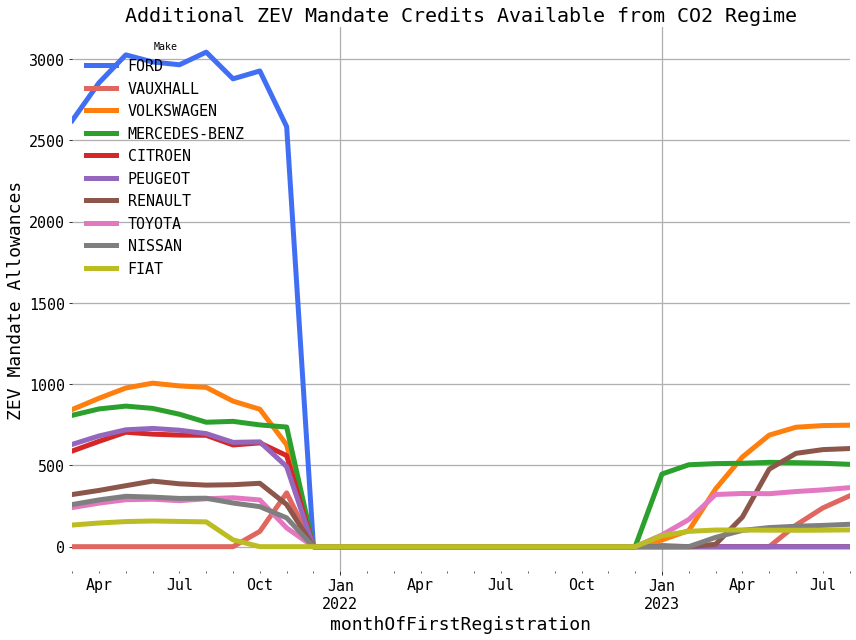

In [29]:
fig, ax = plt.subplots()

df.pivot(index='monthOfFirstRegistration', columns='make', values='co2_to_mandate_allowances')[top_makes].plot(ax=ax)
ax.set_ylabel('ZEV Mandate Allowances')
ax.legend(title='Make', loc='upper left')
ax.set_title('Additional ZEV Mandate Credits Available from CO2 Regime')

plt.show()

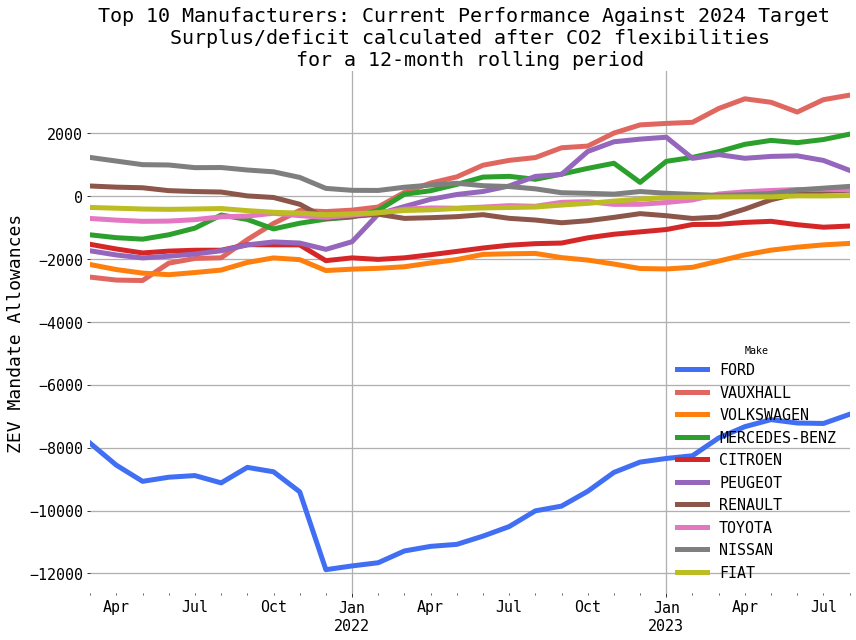

In [30]:
fig, ax = plt.subplots()

df.pivot(index='monthOfFirstRegistration', columns='make', values='ZEV Surplus after CO2')[top_makes].plot(ax=ax)
ax.set_ylabel('ZEV Mandate Allowances')
ax.set_xlabel('')
ax.set_title('Top 10 Manufacturers: Current Performance Against 2024 Target \n Surplus/deficit calculated after CO2 flexibilities \nfor a 12-month rolling period')
ax.legend(title='Make', loc='lower right')

# plt.savefig('plots/top_10_manufacturers_zevm.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

<AxesSubplot:xlabel='monthOfFirstRegistration'>

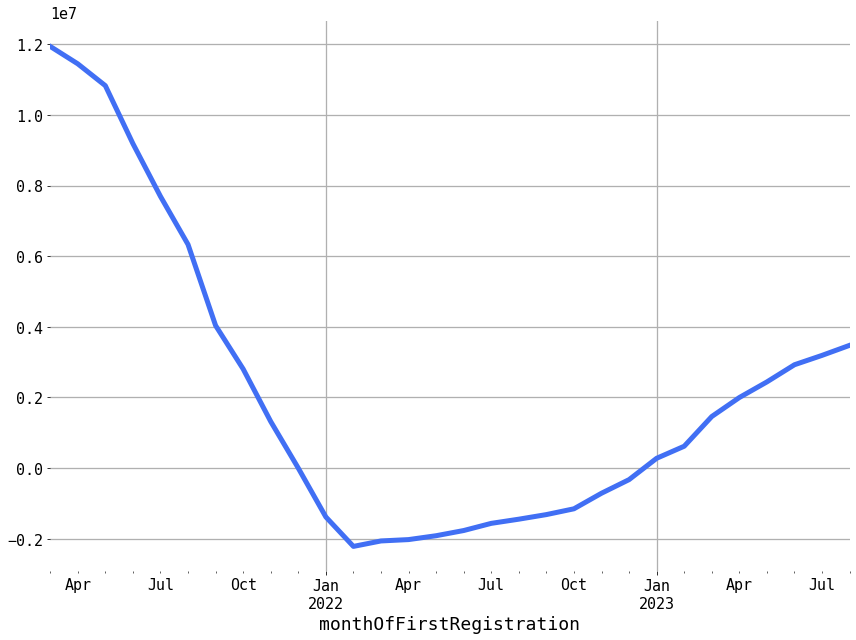

In [31]:
df.groupby(['monthOfFirstRegistration']).sum().co2Compliance.plot()

In [32]:
df

,index,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity,make,co2Target,co2Allowances,co2Compliance,co2ComplianceAdj,co2_to_mandate_allowances,ZEVMallowances,ZEV Surplus,ZEV Surplus after CO2
0,11,2021-03-01 00:00:00+00:00,1506.0,1504.0,2.0,326314.0,LAND ROVER,243.061976,3.655652e+05,3.925121e+04,3.875056e+04,37.650000,1355.4,-148.6,-110.950000
55,11,2021-03-01 00:00:00+00:00,9617.0,9614.0,3.0,1783447.0,TOYOTA,220.205245,2.117053e+06,3.336062e+05,3.293511e+05,240.425000,8655.3,-958.7,-718.275000
85,11,2021-03-01 00:00:00+00:00,3063.0,2961.0,101.0,1022134.0,MAN,543.085422,1.608076e+06,5.859419e+05,5.784682e+05,76.575000,2756.7,-204.3,-127.725000
115,11,2021-03-01 00:00:00+00:00,12836.0,11560.0,1275.0,2038192.0,RENAULT,215.654457,2.492966e+06,4.547735e+05,4.489729e+05,320.900000,11552.4,-7.6,313.300000
145,11,2021-03-01 00:00:00+00:00,1609.0,1596.0,13.0,389809.0,RENAULT TRUCKS,504.166667,8.046500e+05,4.148410e+05,4.095497e+05,40.225000,1448.1,-147.9,-107.675000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,40,2023-08-01 00:00:00+00:00,29895.0,29164.0,729.0,5669288.0,VOLKSWAGEN,201.451193,5.875123e+06,2.058346e+05,1.480154e+05,747.375000,26905.5,-2258.5,-1511.125000
384,40,2023-08-01 00:00:00+00:00,22662.0,21355.0,1265.0,4024157.0,CITROEN,180.890843,3.862924e+06,-1.612331e+05,-1.612331e+05,0.000000,20395.8,-959.2,-959.200000
414,40,2023-08-01 00:00:00+00:00,30095.0,24197.0,5889.0,4527422.0,VAUXHALL,190.106794,4.600014e+06,7.259210e+04,5.220088e+04,312.580121,27085.5,2888.5,3201.080121
444,40,2023-08-01 00:00:00+00:00,100473.0,97367.0,2554.0,20901074.0,FORD,203.273475,1.979213e+07,-1.108946e+06,-1.108946e+06,0.000000,90425.7,-6941.3,-6941.300000


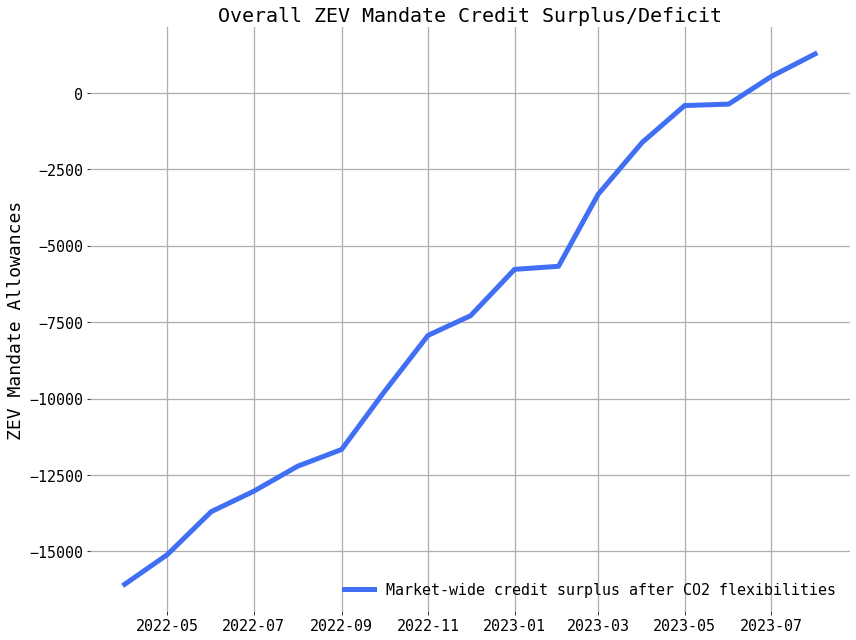

In [33]:
fig, ax = plt.subplots()

plt_df = df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2']

# ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus'], label='Market-wide credit surplus')
ax.plot(plt_df[plt_df.index > '2022-03-01'], label='Market-wide credit surplus after CO2 flexibilities')
# ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2 - Proposed'], label='Proposed Market-wide credit surplus after CO2 flexibilities')
ax.set_ylabel('ZEV Mandate Allowances')

ax.legend(loc='lower right')
ax.set_title('Overall ZEV Mandate Credit Surplus/Deficit')

plt.savefig('plots/van_aggregate_demand_credits.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [34]:
df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2']

monthOfFirstRegistration
2021-03-01 00:00:00+00:00   -17419.575000
2021-04-01 00:00:00+00:00   -19075.775000
2021-05-01 00:00:00+00:00   -20250.650000
2021-06-01 00:00:00+00:00   -19542.050000
2021-07-01 00:00:00+00:00   -19040.925000
2021-08-01 00:00:00+00:00   -18153.600000
2021-09-01 00:00:00+00:00   -16742.739914
2021-10-01 00:00:00+00:00   -16399.752607
2021-11-01 00:00:00+00:00   -16883.094439
2021-12-01 00:00:00+00:00   -21342.600000
2022-01-01 00:00:00+00:00   -20605.500000
2022-02-01 00:00:00+00:00   -19143.300000
2022-03-01 00:00:00+00:00   -17288.000000
2022-04-01 00:00:00+00:00   -16073.600000
2022-05-01 00:00:00+00:00   -15105.700000
2022-06-01 00:00:00+00:00   -13699.500000
2022-07-01 00:00:00+00:00   -13031.500000
2022-08-01 00:00:00+00:00   -12212.600000
2022-09-01 00:00:00+00:00   -11665.500000
2022-10-01 00:00:00+00:00    -9785.900000
2022-11-01 00:00:00+00:00    -7933.700000
2022-12-01 00:00:00+00:00    -7290.900000
2023-01-01 00:00:00+00:00    -5775.500691
2023-02-0

In [35]:
df.columns = [x.replace(' ', '') for x in df.columns]

In [36]:
client = bigquery.Client()
table_id = 'zevMandate.vanRollingPerformance'

job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField('monthOfFirstRegistration', 'DATE'),
        bigquery.SchemaField('make', 'STRING'),
        bigquery.SchemaField('totalSales', 'INTEGER'),
        bigquery.SchemaField('nonzevSales', 'INTEGER'),
        bigquery.SchemaField('zevSales', 'INTEGER'),
        bigquery.SchemaField('co2Activity', 'FLOAT'),
        bigquery.SchemaField('co2Target', 'FLOAT'),
        bigquery.SchemaField('co2Allowances', 'FLOAT'),
        bigquery.SchemaField('co2Compliance', 'FLOAT'),
        bigquery.SchemaField('co2ComplianceAdj', 'FLOAT'),
        bigquery.SchemaField('ZEVMallowances', 'FLOAT'),
        bigquery.SchemaField('ZEVSurplus', 'FLOAT'),
        bigquery.SchemaField('co2_to_mandate_allowances', 'FLOAT'),
        bigquery.SchemaField('ZEVSurplusafterCO2', 'FLOAT')
        
    ]
)
job_config.write_disposition = 'WRITE_TRUNCATE'
job = client.load_table_from_dataframe(df, table_id, job_config=job_config)

job.result()

In [34]:
df['meanCo2'] = df.apply(lambda row: row.co2Activity / row.nonzevSales if row.nonzevSales >0 else np.nan , axis=1)

In [26]:
van_targets[van_targets.make.isin(top_makes)]

NameError: name 'top_makes' is not defined

NameError: name 'df' is not defined

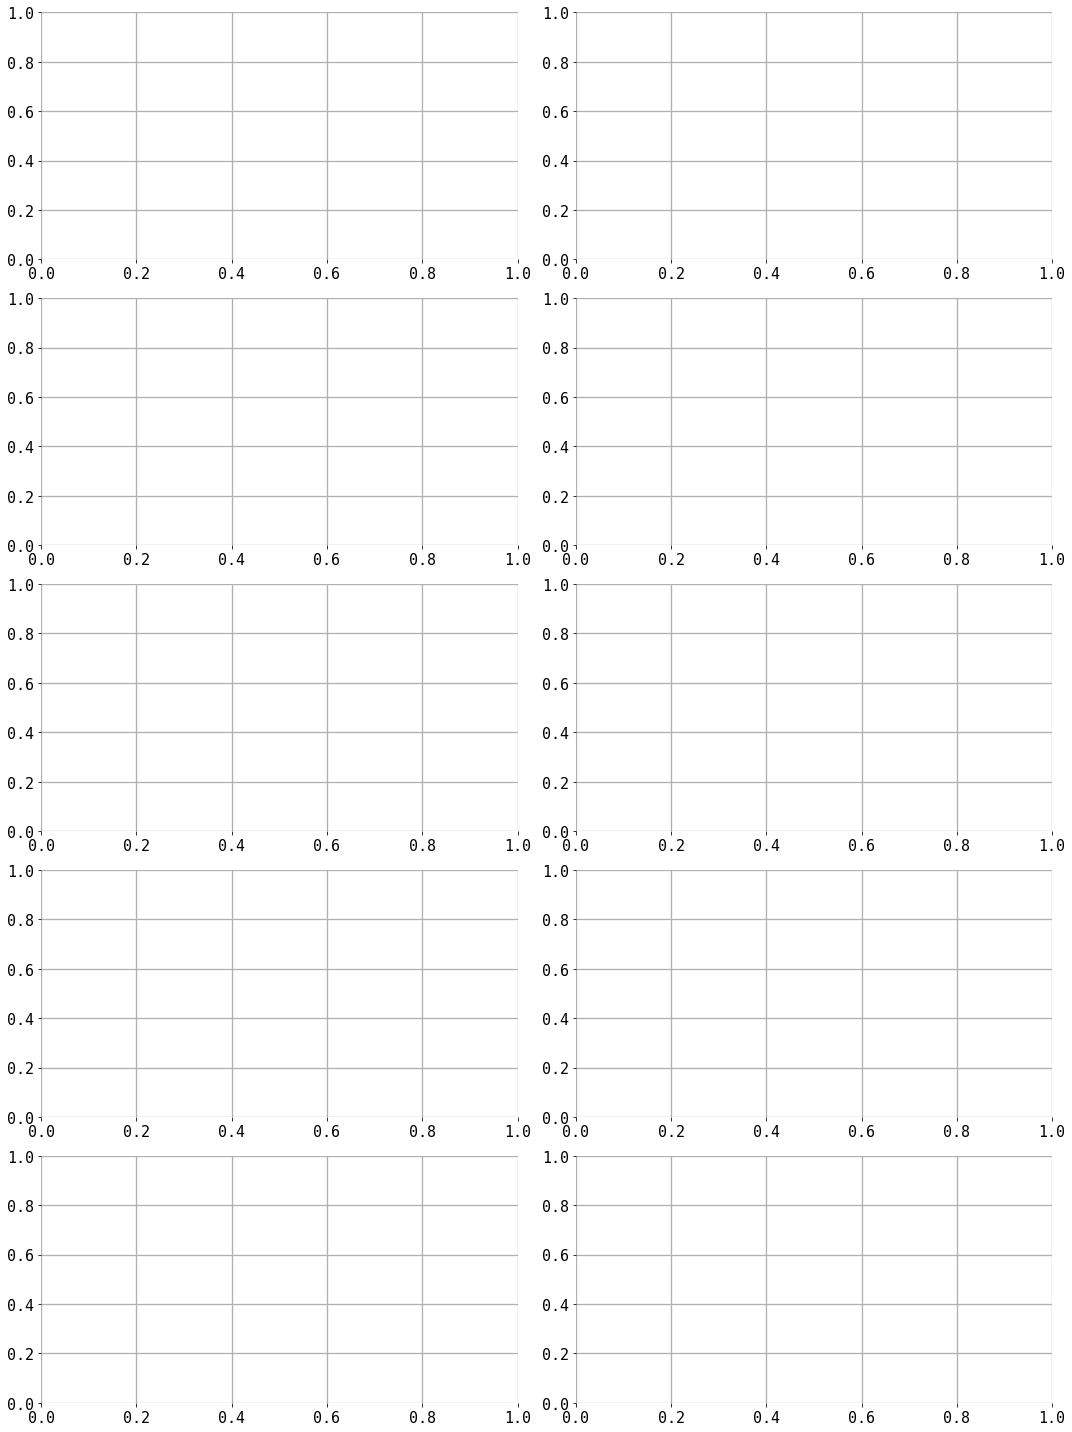

In [27]:
fig, ax = plt.subplots(5, 2, figsize=(15, 20))

# # df.pivot(index='monthOfFirstRegistration', columns='make', values='meanCo2')[top_makes].plot(ax=ax)
# # ax.axhline(car_targets[car_targets.make.isin(top_makes)])
# # ax.set_xlabel('')
# # ax.legend(title='Make', loc='lower right')

plt_df = df.pivot(index='monthOfFirstRegistration', columns='make', values='meanCo2')[top_makes]



for e, make in enumerate(top_makes[:5]):
    ax[e, 0].plot(plt_df[make], c='red')
    ax[e, 0].axhline(van_targets[van_targets.make == make].co2Target.values, c='black', linestyle='--')
    ax[e, 0].set_title(make)
    ax[e, 0].figure.autofmt_xdate()
    # ax[e, 0].set_ylabel('Mean WLPT CO2g/km')
    
for e, make in enumerate(top_makes[5:]):
    ax[e, 1].plot(plt_df[make], c='red')
    ax[e, 1].axhline(van_targets[van_targets.make == make].co2Target.values, c='black', label='2021 Baseline Target', linestyle='--')
    ax[e, 1].set_title(make)
    ax[e, 1].figure.autofmt_xdate()
    # ax[e, 1].set_ylabel('Mean WLPT CO2g/km')
    

fig.text(0.0, 0.5, 'Mean WLTP CO2g/km', va='center', rotation='vertical', fontsize=10)
fig.suptitle('Top 20 Manufacturers: Car CO2 performance against 2021 average \n 12-month rolling average', y=1, fontsize=25)
fig.tight_layout()
# plt.show()

plt.savefig('plots/van_co2.png', transparent=False, bbox_inches='tight', dpi=300)

# ax[0, 0]

In [ ]:
df